In [1]:
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import h5py
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-01-01', freq='MS')


In [2]:

def read_hdf5_file(data_path, data_name):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]

def load_pickle(load_path):
    with open(load_path, 'rb') as file:
        data = pickle.load(file)
    return data

def calc_masked_MSE_loss(outputs, targets, target_months, use_weights=False, zero_class_weight=None):
    ice_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/monthly_ice_mask.nc").mask

    n_active_cells = 0

    for target_months_subset in target_months:
        n_active_cells += ice_mask.sel(month=target_months_subset).sum().values
    
    # Punish predictions of sea ice in ice free zones 
    if use_weights:
        weights = np.where(targets == 0, zero_class_weight, 1)
        loss = np.sum(((targets - outputs) ** 2) * weights) / n_active_cells
    else:
        loss = np.sum((targets - outputs) ** 2) / n_active_cells

    return loss

def anomaly_persistence(start_prediction_month, predict_anomalies=False):
    """
    The anomaly persistence baseline model 
    """

    siconc_anom = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_anom.nc").siconc
    siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
    land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
    siconc_anom *= ~land_mask

    anomaly_to_persist = siconc_anom.sel(time=start_prediction_month - pd.DateOffset(months=1)) 
    months_to_predict_clim = siconc_clim.sel(month=pd.date_range(start_prediction_month, \
        start_prediction_month+pd.DateOffset(months=5), freq='MS').month)

    prediction = months_to_predict_clim + anomaly_to_persist 

    # clip unphysical values outside of [0, 1] 
    prediction = prediction.where(prediction < 1, 1)
    prediction = prediction.where(prediction > 0, 0)

    if predict_anomalies:
        prediction = prediction - months_to_predict_clim

    return prediction

def generate_start_prediction_months(max_month_lead_time=6, max_input_lag_time=12):
    # Construct the date range for the data pairs 
    # Note that this is not continuous due to the missing data in 1987-1988 
    first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=max_month_lead_time+1), freq='MS')
    second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=max_input_lag_time+1), '2024-01', freq='MS')

    return first_range.append(second_range)

prediction_months = generate_start_prediction_months()

# Load in truth sea ice data
nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
sic_land_masked = nsidc_sic.siconc.where(~land_mask, 0)

siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
siconc_clim = siconc_clim.where(~land_mask, 0)


In [3]:

# Load in the predicted data 
val_preds_anom = np.zeros((5, 48, 6, 336, 320))
val_preds_abs = np.zeros((5, 48, 6, 336, 320))
for seed in range(5):
    val_preds_anom[seed,:,:,:,:] = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/UNetRes3_all_sicanom_{seed}_val_predictions.npy")
    val_preds_abs[seed,:,:,:,:] = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/UNetRes3_all_{seed}_val_predictions.npy")

val_targets = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets_anom_regression.h5")["targets_sea_ice_only"]

val_preds_anom_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["ens_member", "init_month", "lead", "y", "x"], val_preds_anom[:,:,:,2:-2,2:-2]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
        ens_member=np.arange(5)
    )
)

val_preds_abs_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["ens_member", "init_month", "lead", "y", "x"], val_preds_abs[:,:,:,2:-2,2:-2]),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=VAL_MONTHS - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
        ens_member=np.arange(5)
    )
)


# Plot an example of anomaly prediction model

Text(0.5, 0.98, 'Init month = 2018-6')

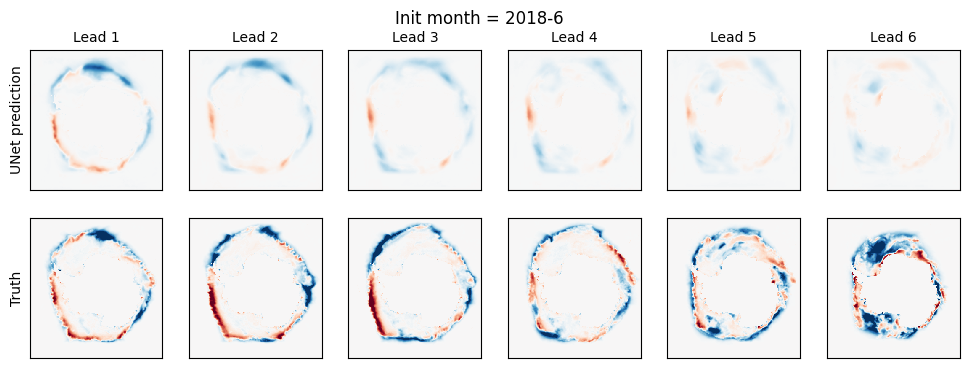

In [28]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

val_time_index = 42
true_time_index = 388+val_time_index
fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=6, sharex=True, sharey=True)

for i in range(6):
    val_pred_ensemble_average = val_preds_anom[:,val_time_index,i,2:-2,2:-2].mean(axis=0)

    axs[0,i].pcolormesh(xgrid, ygrid, val_pred_ensemble_average, cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].pcolormesh(xgrid, ygrid, val_targets[true_time_index,i,:,:], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)

axs[0,0].set_ylabel("UNet prediction")
axs[1,0].set_ylabel("Truth")
init_month = prediction_months[true_time_index-1]
plt.suptitle(f"Init month = {init_month.year}-{init_month.month}")
#plt.savefig(f"../figures/sample_predictions/anomaly_prediction_example.jpg", dpi=300, bbox_inches='tight')

Text(0.5, 0.94, 'Init month = 2015-8')

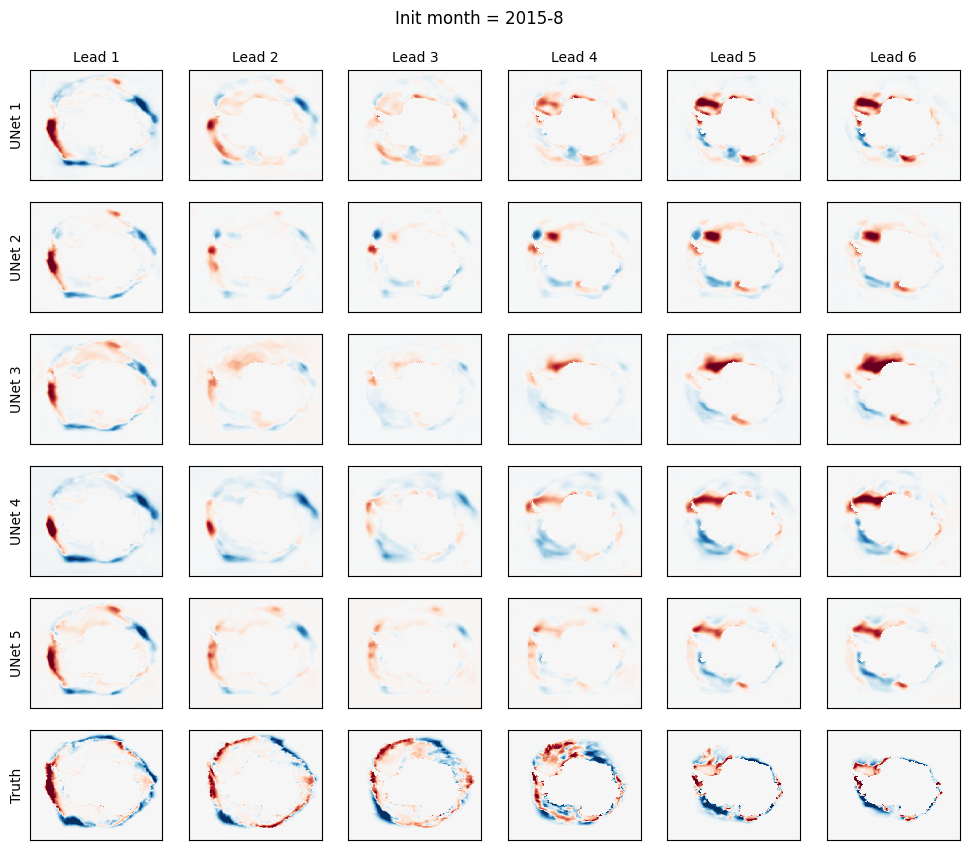

In [150]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

val_time_index = 8
true_time_index = val_start_index+val_time_index
fig, axs = plt.subplots(figsize=(12,10), nrows=6, ncols=6, sharex=True, sharey=True)

for i in range(6):
    for j in range(5):
        val_pred_ensemble_average = val_preds_anom[j,val_time_index,i,2:-2,2:-2]

        axs[j,i].pcolormesh(xgrid, ygrid, val_pred_ensemble_average, cmap='RdBu_r', vmin=-0.4, vmax=0.4)
        axs[j,i].set_yticks([])
        axs[j,0].set_ylabel(f"UNet {j+1}")

    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)
    axs[5,i].pcolormesh(xgrid, ygrid, val_targets[true_time_index,i,:,:], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[5,i].set_xticks([])
    axs[5,i].set_yticks([])

axs[5,0].set_ylabel("Truth")
init_month = prediction_months[true_time_index-1]
plt.suptitle(f"Init month = {init_month.year}-{init_month.month}", y=0.94)
#plt.savefig(f"../figures/sample_predictions/anom_pred_ensemble_example_confidentcorrect.jpg", dpi=300, bbox_inches='tight')

In [12]:
val_preds_anom_ds.siconc

<xarray.DataArray 'siconc' (ens_member: 5, init_month: 48, lead: 6, y: 332,
                            x: 316)> Size: 1GB
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00, -1.03073865e-02,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00, -1.02192480e-02,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00, -1.04763992e-02, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.15150372e-02,  1.12577053e-02,  1.34262051e-02],
...
          [ 3.05720954e-03, -2.05949391e-03,  1.19261444e-04, ...,
            2.83457316e-03, -2.34878366e-03,  4.85255476e-03],
          [-9.15684272e-03, -4.81095910e-03, -1.43700000e-03, ...,
            1.22877897e-03,  3.70398699e-03, -1.50741022e-02],
          [-1.53725334e-02,  1.03396142e-03, -1.50314346e-02, ...,
            1.11948568e-02, -1.88890623e-03,  1.21413982e-02]],

         [[ 2.97362963e-03, -8.74055270e-03, -7.12638209e-03, ...,
            1.55316843e-02,  6.74607791e-03,  5.09361969e-03],
          [-5.29022794e-03, -6.24360982e-03, -6.58728322e-03, ...,
           -9.62930173e-03,  2.14017928e-04, -1.36542984e-03],
          [ 2.55236216e-03,  6.36177137e-03, -3.80637147e-03, ...,
            2.66912696e-03,  9.02669225e-03,  7.07929675e-03],
          ...,
          [-5.64888061e-04, -5.58692357e-03,  4.61498369e-03, ...,
            5.30775869e-03,  7.54225114e-03,  2.09616255e-02],
          [-1.23725999e-02, -1.23765329e-02,  6.56711543e-03, ...,
            1.78354047e-03,  1.20564895e-02,  8.49586446e-03],
          [-6.37046574e-03, -6.67114323e-03, -3.25740478e-03, ...,
            1.86645165e-02,  5.98987471e-03,  1.92508232e-02]]]]])
Coordinates:
  * y           (y) float32 1kB 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * x           (x) float32 1kB -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * init_month  (init_month) datetime64[ns] 384B 2014-12-01 ... 2018-11-01
  * lead        (lead) int64 48B 1 2 3 4 5 6
  * ens_member  (ens_member) int64 40B 0 1 2 3 4

# Calculate model errors by month and lead time

In [14]:

mae_by_month_and_lead_anom = np.zeros((12, 6))
mae_by_month_and_lead_abs = np.zeros((12, 6))
nmae_by_month_and_lead_anom = np.zeros((12, 6))
nmae_by_month_and_lead_abs = np.zeros((12, 6))

cell_area = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/NSIDC_SPS_grid_areas.nc").cell_area
siconc_clim = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/siconc_clim.nc").siconc
siconc_clim_area = (siconc_clim * cell_area).sum(("x","y"))

for lead in range(1,7): 
    prediction_times = VAL_MONTHS - pd.DateOffset(months=1) + pd.DateOffset(months=lead)
    for target_month in range(1,13):
        # get prediction for anomaly forecast
        val_pred_ens_mean_anom = val_preds_anom_ds.siconc.sel(lead=lead).mean('ens_member')

        init_month = (target_month - lead - 1) % 12 + 1
        val_pred_subset_anom = val_pred_ens_mean_anom.where(val_pred_ens_mean_anom.init_month.dt.month==init_month, drop=True)

        # Add anomaly to climatology to retrieve true sea ice 
        val_pred_subset_anom += siconc_clim.sel(month=target_month)
        val_pred_subset_anom = val_pred_subset_anom.where(val_pred_subset_anom < 1, 1)
        val_pred_subset_anom = val_pred_subset_anom.where(val_pred_subset_anom > 0, 0)
        
        # get prediction for abs forecast
        val_pred_ens_mean_abs = val_preds_abs_ds.siconc.sel(lead=lead).mean('ens_member')
        val_pred_subset_abs = val_pred_ens_mean_abs.where(val_pred_ens_mean_abs.init_month.dt.month==init_month, drop=True)

        # get truth 
        truth = sic_land_masked.sel(time=prediction_times)
        truth = truth.where(truth.time.dt.month==target_month, drop=True)

        # calculate mean error over all times in val set 
        diff_abs = np.abs(val_pred_subset_abs - truth)
        diff_anom = np.abs(val_pred_subset_anom - truth)
        area_error_abs = (diff_abs * cell_area).sum(dim=("x","y")) / siconc_clim_area.sel(month=init_month)
        area_error_anom = (diff_anom * cell_area).sum(dim=("x","y")) / siconc_clim_area.sel(month=init_month)

        nmae_by_month_and_lead_abs[target_month-1, lead-1] = area_error_abs.mean()
        nmae_by_month_and_lead_anom[target_month-1, lead-1] = area_error_anom.mean()

        # sia_truth = (truth * cell_area).sum(dim=("x", "y")) / 1e12
        # sia_pred_anom = (val_pred_subset_anom * cell_area).sum(dim=("x", "y")) / 1e12
        # sia_pred_abs = (val_pred_subset_abs * cell_area).sum(dim=("x", "y")) / 1e12

        # mae_by_month_and_lead_anom[target_month-1, lead-1] = np.abs(sia_pred_anom.values - sia_truth.values).mean()
        # mae_by_month_and_lead_abs[target_month-1, lead-1] = np.abs(sia_pred_abs.values - sia_truth.values).mean()

        #nmae_by_month_and_lead_abs[target_month-1, lead-1] = np.abs((sia_pred_abs.values - sia_truth.values)/sia_truth.values).mean()



In [97]:
# calculate the same metrics for anomaly persistence and linear 
mae_by_month_and_lead_persist = np.zeros((12, 6))
nmae_by_month_and_lead_persist = np.zeros((12, 6))

for lead in range(1,7): 
    prediction_times = VAL_MONTHS - pd.DateOffset(months=1) + pd.DateOffset(months=lead)
    for target_month in range(1,13):
        init_month = (target_month - lead - 1) % 12 + 1
        val_pred_persist_subset = val_preds_persist_ds.siconc.sel(lead=lead)
        val_pred_persist_subset = val_pred_persist_subset.where(val_pred_persist_subset.init_month.dt.month==init_month, drop=True)

        # get truth 
        truth = nsidc_sic.siconc.sel(time=prediction_times)
        truth = truth.where(truth.time.dt.month==target_month, drop=True)

        area_mae = np.abs(np.sum((truth.values - pred_subset.values) * cell_area.values, axis=(1,2))) / 1e12
        
        sia_truth = (truth * cell_area).sum(dim=("x", "y")) / 1e12
        sia_pred_persist = (val_pred_persist_subset * cell_area).sum(dim=("x", "y")) / 1e12

        mae_by_month_and_lead_persist[target_month-1, lead-1] = np.abs(sia_pred_persist.values - sia_truth.values).mean()
        nmae_by_month_and_lead_persist[target_month-1, lead-1] = np.abs((sia_pred_persist.values - sia_truth.values)/sia_truth.values).mean()

mae_by_month_and_lead_lin = np.zeros((12, 6))
nmae_by_month_and_lead_lin = np.zeros((12, 6))

for target_month in range(1,13):
    linear_forecast.sel(time=val_pred_time_subset).where(linear_forecast.time.dt.month==target_month, drop=True)
    


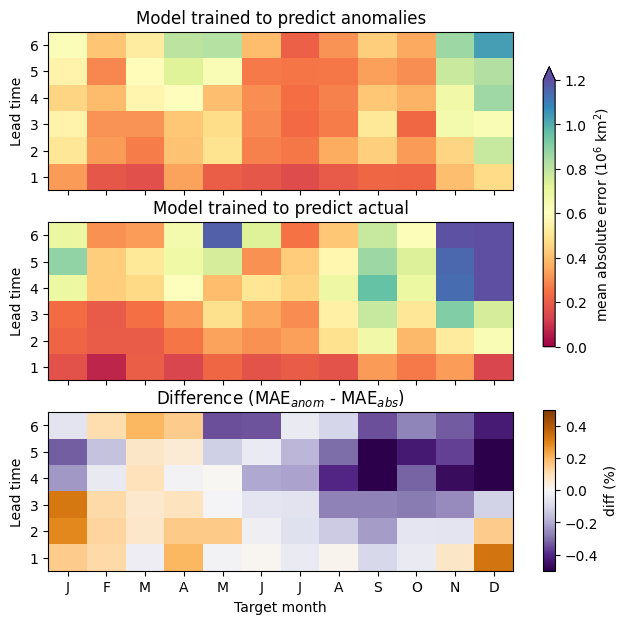

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, mae_by_month_and_lead_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=1.2)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("Model trained to predict anomalies")

axs[1].pcolormesh(x, y, mae_by_month_and_lead_abs.T, cmap='Spectral', shading='flat', vmin=0, vmax=1.2)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Model trained to predict actual")

cax2 = axs[2].pcolormesh(x, y, (mae_by_month_and_lead_anom-mae_by_month_and_lead_abs).T, cmap='PuOr_r', \
    shading='flat', vmin=-0.5, vmax=0.5)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_xlabel("Target month")
axs[2].set_title(r"Difference (MAE$_{anom}$ - MAE$_{abs}$)")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'mean absolute error (10$^6$ km$^2$)', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff (%)', orientation='vertical')

#plt.savefig("../figures/anomaly_vs_abs_pred_forecast_MAE.jpg", dpi=300, bbox_inches='tight')

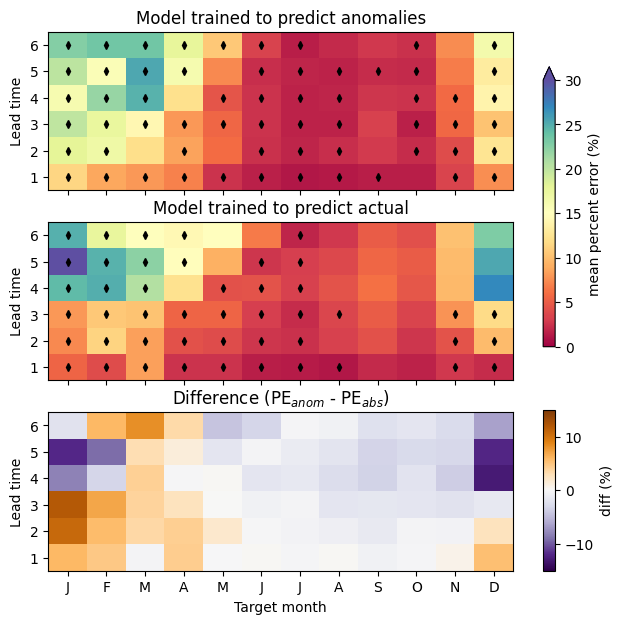

In [120]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = nmae_by_month_and_lead_anom < nmae_by_month_and_lead_persist
cax = axs[0].pcolormesh(x, y, 100 * nmae_by_month_and_lead_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=30)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("Model trained to predict anomalies")

for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            axs[0].plot(x_centers[i], y_centers[j], 'dk', markersize=4) 

exceeds_persistence = nmae_by_month_and_lead_abs < nmae_by_month_and_lead_persist
axs[1].pcolormesh(x, y, 100 * nmae_by_month_and_lead_abs.T, cmap='Spectral', shading='flat', vmin=0, vmax=30)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Model trained to predict actual")
for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            axs[1].plot(x_centers[i], y_centers[j], 'dk', markersize=4) 

cax2 = axs[2].pcolormesh(x, y, 100 * (nmae_by_month_and_lead_anom-nmae_by_month_and_lead_abs).T, cmap='PuOr_r', \
    shading='flat', vmin=-15, vmax=15)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_xlabel("Target month")
axs[2].set_title(r"Difference (PE$_{anom}$ - PE$_{abs}$)")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'mean percent error (%)', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff (%)', orientation='vertical')

plt.savefig("../figures/anomaly_vs_abs_pred_forecast_percent_error.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_17357/2314589547.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Loss')

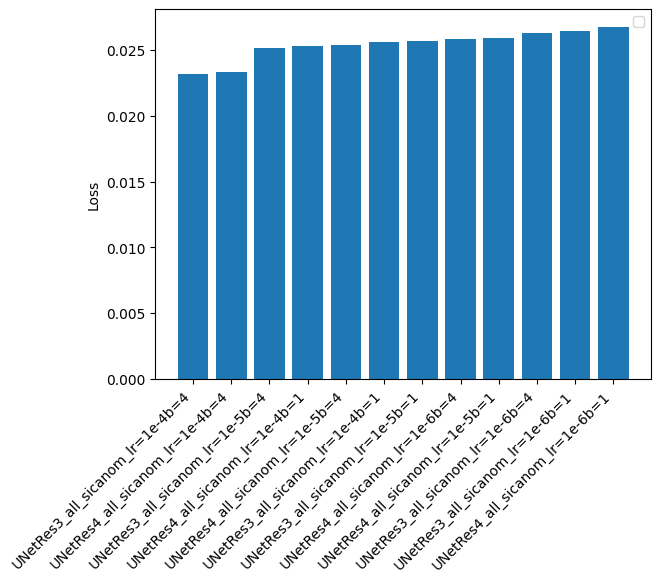

In [3]:
val_losses = {}
for arch in ["UNetRes4", "UNetRes3"]:
    for lr in [1e-4, 1e-5, 1e-6]:
        for batch_size in [1, 4]:
            # set hyperparams
            if lr == 1e-4: lr_str = "1e-4"
            if lr == 1e-5: lr_str = "1e-5"
            if lr == 1e-6: lr_str = "1e-6"
            model_name = f"{arch}_all_sicanom_lr={lr_str}b={batch_size}"

            model_config_dict = load_pickle(f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl")
            val_losses[model_name] = model_config_dict["best_val_loss"]

sorted_val_losses = sorted(val_losses.items(), key=lambda item: item[1])
labels, values = zip(*sorted_val_losses)

plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.ylabel("Loss")


# Plot diagnostics for the bigger ensemble

In [6]:
unet_preds_ds = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/models/experiments/anom_ensemble_2/valtest_pred.nc")
siconc_anom_truth = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_anom.nc").siconc


Text(0, 0.5, 'Truth')

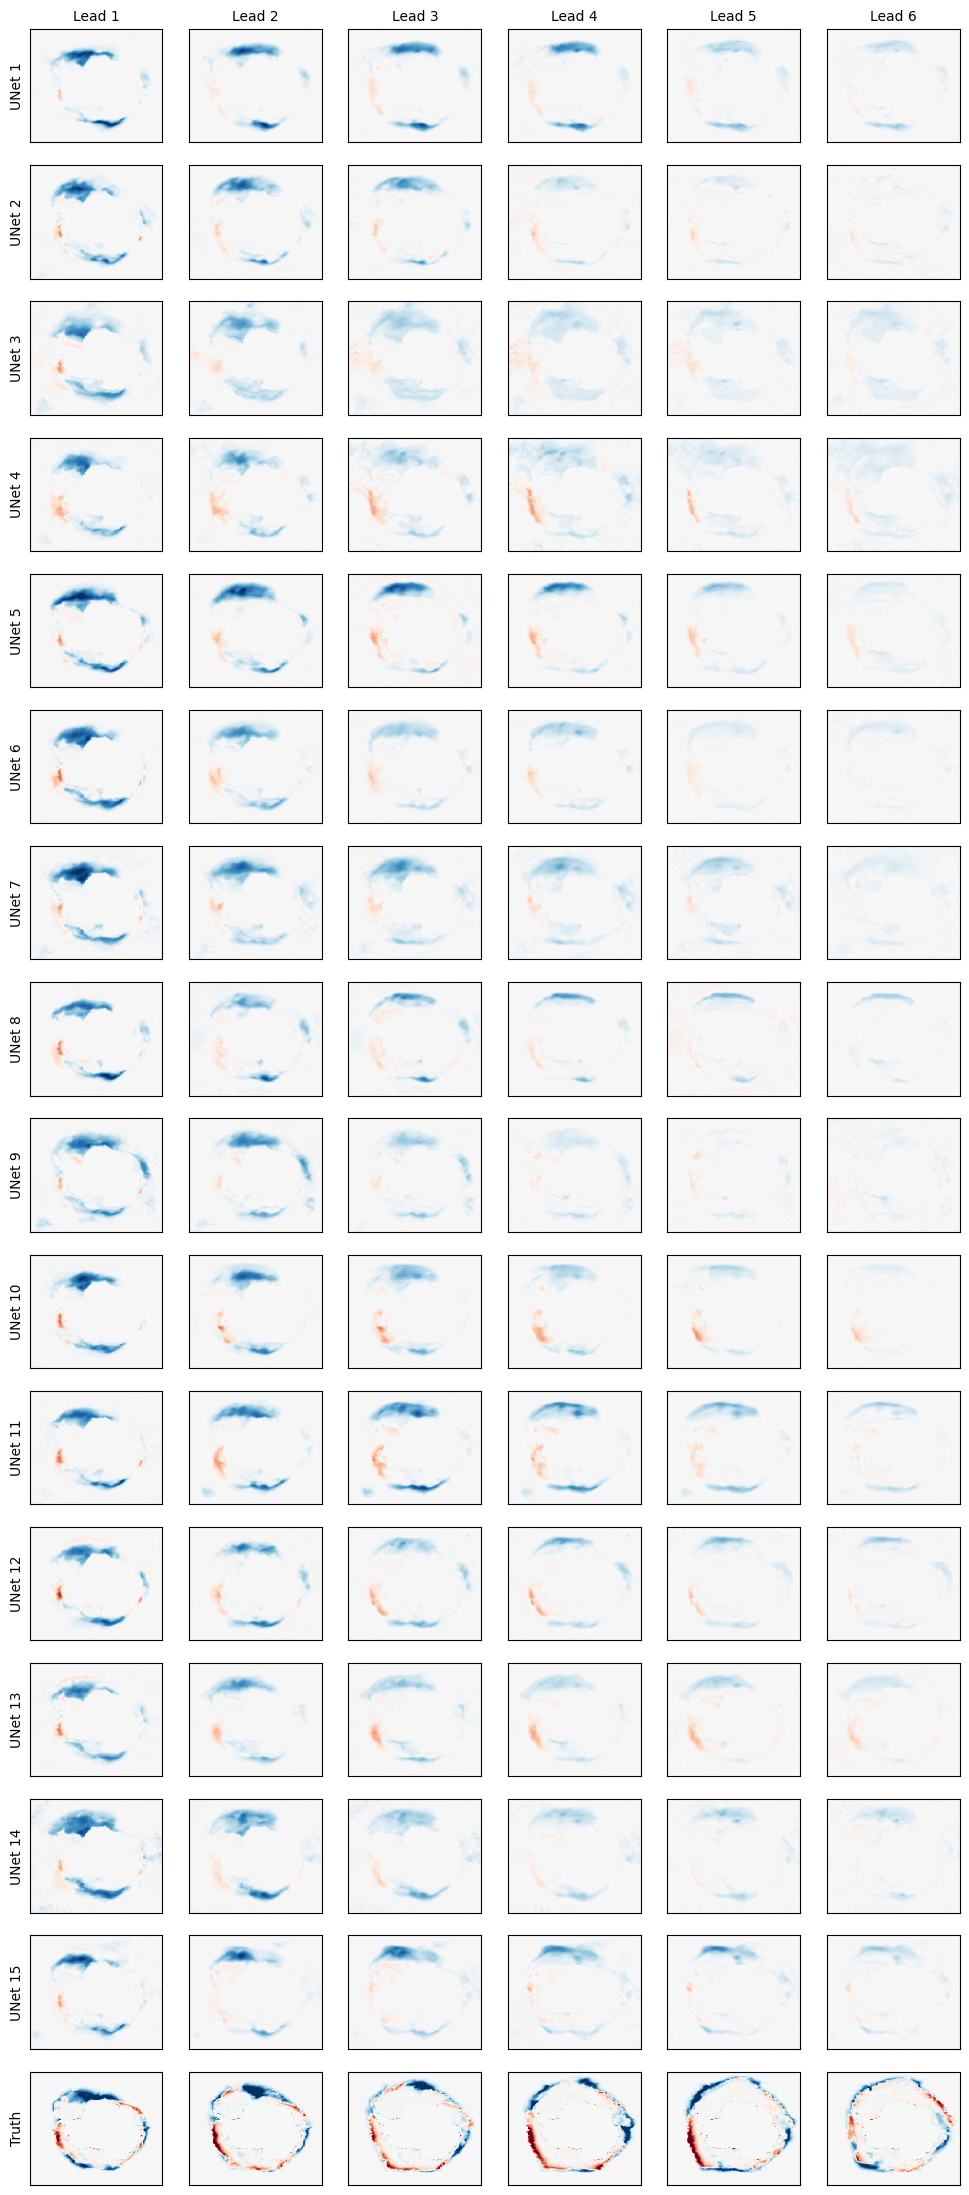

In [42]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

fig, axs = plt.subplots(figsize=(12,28), nrows=16, ncols=6, sharex=True, sharey=True)

for i in range(6):
    for j in range(15):
        axs[j,i].pcolormesh(xgrid, ygrid, unet_preds_ds.siconc.isel(init_month=40, lead=i, ens_member=j), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
        #axs[j,i].pcolormesh(xgrid, ygrid, val_predictions[j,0,i,2:-2,2:-2], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
        axs[j,i].set_yticks([])
        axs[j,0].set_ylabel(f"UNet {j+1}")

    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)
    axs[15,i].pcolormesh(xgrid, ygrid, siconc_anom_truth.sel(time=VAL_MONTHS[i+40]), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[15,i].set_xticks([])
    axs[15,i].set_yticks([])

axs[15,0].set_ylabel("Truth")


#### mean prediction example 
shows anomaly persistence then fades to climatology

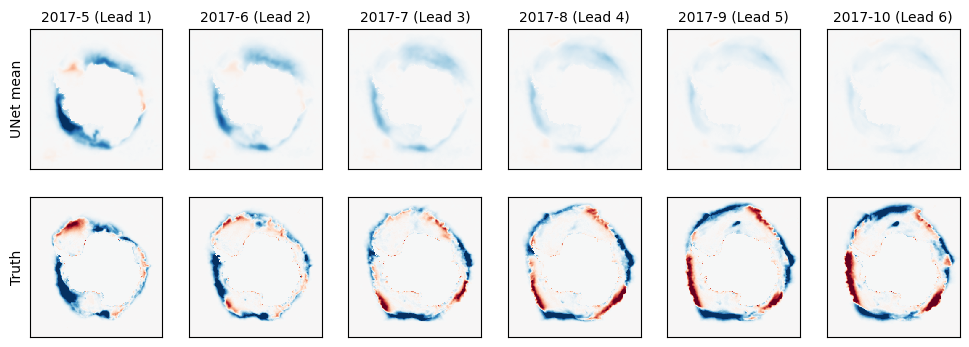

In [41]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=6, sharex=True, sharey=True)

init_month = 28
for i in range(6):
    axs[0,i].pcolormesh(xgrid, ygrid, unet_preds_ds.siconc.isel(init_month=init_month, lead=i).mean("ens_member"), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    #axs[j,i].pcolormesh(xgrid, ygrid, val_predictions[j,0,i,2:-2,2:-2], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[0,i].set_yticks([])
    axs[0,0].set_ylabel(f"UNet mean")

    axs[0,i].set_title(f"{VAL_MONTHS[i+init_month].year}-{VAL_MONTHS[i+init_month].month} (Lead {i+1})", fontsize=10)
    axs[1,i].pcolormesh(xgrid, ygrid, siconc_anom_truth.sel(time=VAL_MONTHS[i+init_month]), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])

axs[1,0].set_ylabel("Truth")
plt.savefig("../figures/anomaly_prediction/ensemble_mean_pred_example.jpg", dpi=300, bbox_inches='tight')

#### With std

Text(0, 0.5, 'Truth')

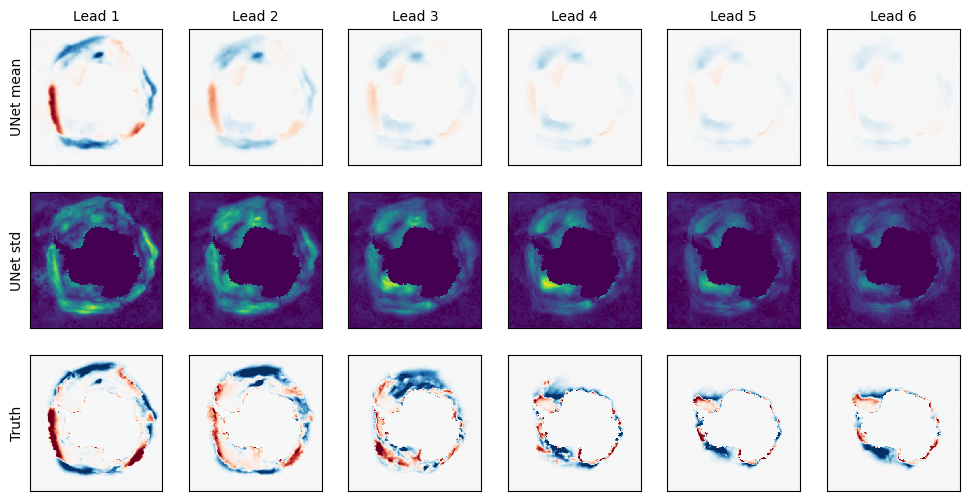

In [25]:
xgrid = nsidc_sic.xgrid / 1e6
ygrid = nsidc_sic.ygrid / 1e6

fig, axs = plt.subplots(figsize=(12,6), nrows=3, ncols=6, sharex=True, sharey=True)

for i in range(6):
    axs[0,i].pcolormesh(xgrid, ygrid, unet_preds_ds.siconc.isel(init_month=init_month, lead=i).mean("ens_member"), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    #axs[j,i].pcolormesh(xgrid, ygrid, val_predictions[j,0,i,2:-2,2:-2], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[0,i].set_yticks([])
    axs[0,0].set_ylabel(f"UNet mean")

    axs[1,i].pcolormesh(xgrid, ygrid, unet_preds_ds.siconc.isel(init_month=init_month, lead=i).std("ens_member"), cmap='viridis', vmin=0, vmax=0.1)
    #axs[j,i].pcolormesh(xgrid, ygrid, val_predictions[j,0,i,2:-2,2:-2], cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[1,i].set_yticks([])
    axs[1,0].set_ylabel(f"UNet std")


    axs[0,i].set_title(f"Lead {i+1}", fontsize=10)
    axs[2,i].pcolormesh(xgrid, ygrid, siconc_anom_truth.sel(time=VAL_MONTHS[i+init_month]), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

axs[2,0].set_ylabel("Truth")


In [4]:
def calculate_error_stats(pred_ds, predict_anomalies=True):
    mae_by_month_and_lead_anom = np.zeros((12, 6))
    nmae_by_month_and_lead_anom = np.zeros((12, 6))
    integrated_ice_edge_error = np.zeros((12, 6))

    cell_area = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/NSIDC_SPS_grid_areas.nc").cell_area

    for lead in range(1,7): 
        prediction_times = pd.to_datetime(pred_ds.init_month) + pd.DateOffset(months=lead)
        for target_month in range(1,13):
            # get prediction for anomaly forecast
            pred_lead = pred_ds.siconc.sel(lead=lead)

            init_month = (target_month - lead - 1) % 12 + 1
            pred_subset = pred_lead.where(pred_lead.init_month.dt.month==init_month, drop=True)

            # Add anomaly to climatology to retrieve true sea ice 
            if predict_anomalies:
                pred_subset += siconc_clim.sel(month=target_month)
                pred_subset = pred_subset.where(pred_subset < 1, 1)
                pred_subset = pred_subset.where(pred_subset > 0, 0)
            
            # get truth 
            truth = nsidc_sic.siconc.sel(time=prediction_times)
            truth = truth.where(truth.time.dt.month==target_month, drop=True)

            # calculate mean error over all times in val set 
            area_mae = np.abs(np.sum((truth.values - pred_subset.values) * cell_area.values, axis=(1,2))) / 1e12

            sie_pred = pred_subset > 0.15
            sie_truth = truth > 0.15 
            
            iiee = np.sum(np.logical_xor(sie_pred.values, sie_truth.values) * cell_area.values, axis=(1,2)) / 1e12
            integrated_ice_edge_error[target_month-1, lead-1] = iiee.mean()

            sia_truth = (truth * cell_area).sum(dim=("x", "y")) / 1e12

            mae_by_month_and_lead_anom[target_month-1, lead-1] = area_mae.mean()

            # get the percent error 
            nmae_by_month_and_lead_anom[target_month-1, lead-1] = (area_mae / sia_truth.values).mean()
    
    return mae_by_month_and_lead_anom, nmae_by_month_and_lead_anom, integrated_ice_edge_error


# do the persistence forecast
valtest_start_prediction_months = VAL_MONTHS.append(TEST_MONTHS)

anomaly_persistence_pred = np.zeros((len(valtest_start_prediction_months), 6, 332, 316))
for i, start_prediction_month in enumerate(valtest_start_prediction_months):
    anomaly_persistence_pred[i,:,:,:] = anomaly_persistence(start_prediction_month).values

val_preds_persist_ds = xr.Dataset(
    data_vars=dict(
        siconc=(["init_month", "lead", "y", "x"], anomaly_persistence_pred),
    ),
    coords=dict(
        y=("y", nsidc_sic.ygrid.data),
        x=("x", nsidc_sic.xgrid.data),
        init_month=valtest_start_prediction_months - pd.DateOffset(months=1),
        lead=np.arange(1,7,1),
    )
)

# retrieve the linear forecast
linear_forecast = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/linear_forecasts/linear_forecast_all_years.nc").siconc
linear_forecast = linear_forecast.rename({"xgrid": "x", "ygrid": "y"})
linear_forecast = linear_forecast.where(~land_mask, 0)



In [7]:
val_init_months = VAL_MONTHS - pd.DateOffset(months=1)

mae_persist, nmae_persist, iiee_persist = calculate_error_stats(val_preds_persist_ds, predict_anomalies=False)
mae_unet, nmae_unet, iiee_unet = calculate_error_stats(unet_preds_ds.mean("ens_member"), predict_anomalies=True)

_, nmae_persist_val, _ = calculate_error_stats(val_preds_persist_ds.sel(init_month=val_init_months), predict_anomalies=False)
_, nmae_unet_val, _ = calculate_error_stats(unet_preds_ds.mean("ens_member").sel(init_month=val_init_months), predict_anomalies=True)

In [8]:
_, nmae_unet_anom, _ = calculate_error_stats(val_preds_anom_ds.mean("ens_member"), predict_anomalies=True)
_, nmae_unet_abs, _ = calculate_error_stats(val_preds_abs_ds.mean("ens_member"), predict_anomalies=False)


In [22]:
for target_month in range(1,13):
    lin_subset = linear_forecast.sel(time=valtest_start_prediction_months).where(linear_forecast.time.dt.month==target_month)
    

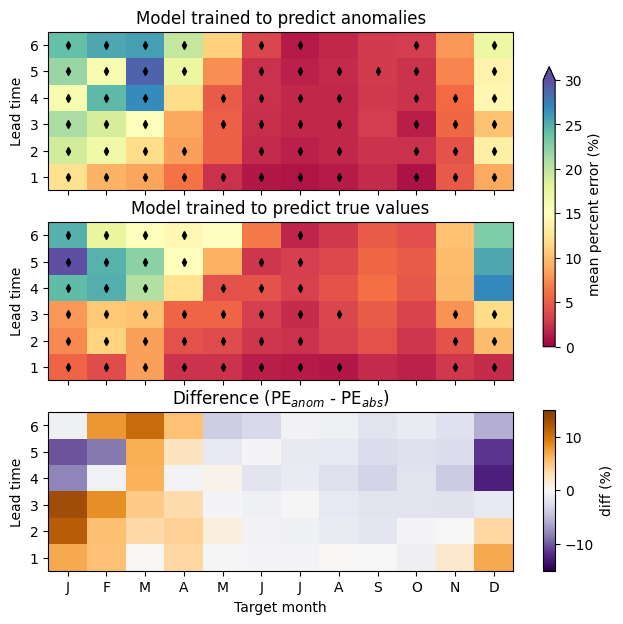

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = nmae_unet_anom < nmae_persist_val
cax = axs[0].pcolormesh(x, y, 100 * nmae_unet_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=30)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("Model trained to predict anomalies")

for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            axs[0].plot(x_centers[i], y_centers[j], 'dk', markersize=4) 

exceeds_persistence = nmae_unet_abs < nmae_persist_val
axs[1].pcolormesh(x, y, 100 * nmae_unet_abs.T, cmap='Spectral', shading='flat', vmin=0, vmax=30)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Model trained to predict true values")
for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            axs[1].plot(x_centers[i], y_centers[j], 'dk', markersize=4) 

cax2 = axs[2].pcolormesh(x, y, 100 * (nmae_unet_anom-nmae_unet_abs).T, cmap='PuOr_r', \
    shading='flat', vmin=-15, vmax=15)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_xlabel("Target month")
axs[2].set_title(r"Difference (PE$_{anom}$ - PE$_{abs}$)")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'mean percent error (%)', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff (%)', orientation='vertical')

plt.savefig("../figures/anomaly_prediction/anomaly_vs_abs_pred_forecast_percent_error.jpg", dpi=300, bbox_inches='tight')

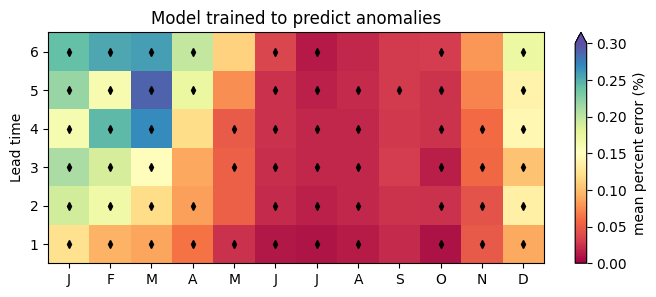

In [19]:
plt.figure(figsize=(8,3))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

plt.pcolormesh(x, y, nmae_unet_anom.T, cmap='Spectral', shading='flat', vmin=0, vmax=0.3)
plt.yticks(y_centers, labels=np.arange(1,7,1))
plt.title("Model trained to predict anomalies")
plt.ylabel("Lead time")

exceeds_persistence = nmae_unet_anom < nmae_persist_val
for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            plt.plot(x_centers[i], y_centers[j], 'dk', markersize=4) 
            
plt.xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.colorbar(label=r'mean percent error (%)', orientation='vertical', extend='max')

plt.savefig("../figures/anomaly_prediction/anomaly_forecast_percent_error.jpg", dpi=300, bbox_inches='tight')

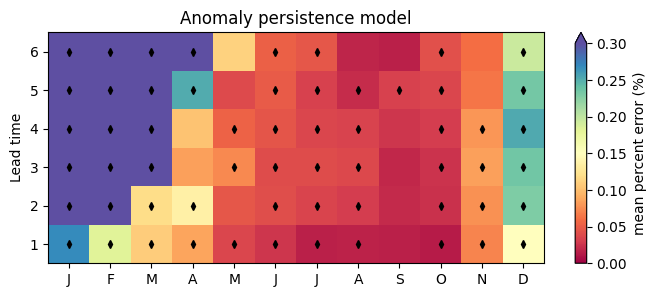

In [22]:
plt.figure(figsize=(8,3))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

plt.pcolormesh(x, y, nmae_persist_val.T, cmap='Spectral', shading='flat', vmin=0, vmax=0.3)
plt.yticks(y_centers, labels=np.arange(1,7,1))
plt.title("Anomaly persistence model")
plt.ylabel("Lead time")

exceeds_persistence = nmae_unet_anom < nmae_persist_val
for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            plt.plot(x_centers[i], y_centers[j], 'dk', markersize=4) 
            
plt.xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.colorbar(label=r'mean percent error (%)', orientation='vertical', extend='max')

plt.savefig("../figures/anomaly_prediction/persistence_forecast_percent_error.jpg", dpi=300, bbox_inches='tight')

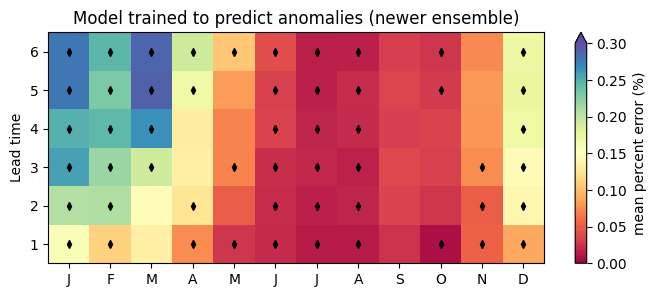

In [24]:
plt.figure(figsize=(8,3))

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

plt.pcolormesh(x, y, nmae_unet_val.T, cmap='Spectral', shading='flat', vmin=0, vmax=0.3)
plt.yticks(y_centers, labels=np.arange(1,7,1))
plt.title("Model trained to predict anomalies (newer ensemble)")
plt.ylabel("Lead time")

exceeds_persistence = nmae_unet_val < nmae_persist_val
for i in range(12):
    for j in range(6):
        if exceeds_persistence[i, j]:
            plt.plot(x_centers[i], y_centers[j], 'dk', markersize=4) 
            
plt.xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.colorbar(label=r'mean percent error (%)', orientation='vertical', extend='max')

#plt.savefig("../figures/anomaly_prediction/anomaly_forecast_percent_error.jpg", dpi=300, bbox_inches='tight')

# 